In [1]:
import pandas as pd
import numpy as np
# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   tf.random.set_seed(rs)
   np.random.seed(rs)

reset_random_seeds(rs)

dir_path = './data/humanModel/dataset_v0.csv'

LEFT = 0
DOWN = 3
RIGHT = 2
UP = 1

In [2]:
data = pd.read_csv(dir_path)
data.columns = data.columns.str.replace(' ', '')

data.head()

,code,step,computer_x,computer_y,human_x,human_y,stag_x,stag_y,shrub1_x,shrub1_y,shrub2_x,shrub2_y,shrub3_x,shrub3_y,human_action
0,-N2gl9wHXMJoXRg5OyiP,1,4,0,0,0,2,2,1,4,3,0,1,2,40
1,-N2gl9wHXMJoXRg5OyiP,2,4,1,0,1,3,2,1,4,3,0,1,2,39
2,-N2gl9wHXMJoXRg5OyiP,3,4,2,1,1,3,1,1,4,3,0,1,2,40
3,-N2gl9wHXMJoXRg5OyiP,4,4,1,1,2,4,1,1,4,3,0,2,2,39
4,-N2gl9wHXMJoXRg5OyiP,5,4,0,2,2,4,1,1,4,3,0,3,3,39


In [3]:
data.columns

Index(['code', 'step', 'computer_x', 'computer_y', 'human_x', 'human_y',
       'stag_x', 'stag_y', 'shrub1_x', 'shrub1_y', 'shrub2_x', 'shrub2_y',
       'shrub3_x', 'shrub3_y', 'human_action'],
      dtype='object')

In [4]:
# https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Preproccessing on the data

In [5]:
data['human_action'] = LabelEncoder().fit_transform(data['human_action'])
# data.set_index('code', inplace=True)
# Drop unused features ("code", "step").
data = data.drop(columns=['code', 'step'], axis=1)

# Convert strng to int
data = data.apply(pd.to_numeric)

# Split into train, validation and test data

In [6]:
y = data.pop('human_action') # Pop the target
X = data.to_numpy()
# X = (X - X.mean()) / X.std()
X = (X - X.min()) / (X.max() - X.min())

# train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.2, random_state = rs)

freqs = pd.DataFrame({"Training dataset": [(y_train == 0).sum(),(y_train == 1).sum(),(y_train == 2).sum(), (y_train == 3).sum()],
                      "Test dataset": [(y_test == 0).sum(),(y_test == 1).sum(),(y_test == 2).sum(),(y_test == 3).sum()],
                      "Total": [(y_train == 0).sum()+(y_test == 0).sum(),(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 2).sum()+(y_test == 2).sum(),(y_train == 3).sum()+(y_test == 3).sum()]},
                     index=["left", "up", "right", "down"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
left,444,106,550
up,438,129,567
right,513,119,632
down,531,128,659


# Transform target to one-hot encoding

In [7]:
# n_values = np.max(y_train) + 1
# y_train = np.eye(n_values)[y_train]

# n_values = np.max(y_test) + 1
# y_test = np.eye(n_values)[y_test]

In [8]:
print(len(y_train), 'training examples')
print(len(y_test), 'test examples')

1926 training examples
482 test examples


In [9]:
type(X_train)

numpy.ndarray

In [10]:
X_train.shape

(1926, 12)

# Build the model

In [11]:
input_shape = X_train.shape[1]
num_classes = 4

X_input = Input(shape=input_shape)
X = X_input
X = Dense(64, activation='relu')(X)
X = Dense(24, activation="relu")(X)
# X = tf.keras.layers.Dropout(0.3)(X)
# Output Layer with # of actions: 4 nodes (left, right, up, down)
X = Dense(num_classes, activation="softmax")(X)

model = Model(inputs = X_input, outputs = X)

In [12]:
model.compile(optimizer='adam',
            # loss='sparse_categorical_crossentropy',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 100       
Total params: 2,492
Trainable params: 2,492
Non-trainable params: 0
_________________________________________________________________


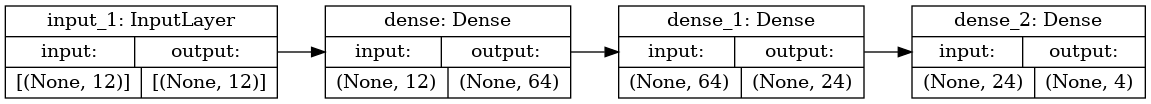

In [14]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# Train the model

In [15]:
epochs = 200
batch_size = 64
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/200


/home/ido/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


31/31 [==============================] - 0s 4ms/step - loss: 1.3685 - accuracy: 0.2845 - val_loss: 1.3565 - val_accuracy: 0.3071
Epoch 2/200
31/31 [==============================] - 0s 1ms/step - loss: 1.3288 - accuracy: 0.3769 - val_loss: 1.3173 - val_accuracy: 0.3776
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 1.2920 - accuracy: 0.4164 - val_loss: 1.2849 - val_accuracy: 0.3859
Epoch 4/200
31/31 [==============================] - 0s 1ms/step - loss: 1.2575 - accuracy: 0.4341 - val_loss: 1.2511 - val_accuracy: 0.4046
Epoch 5/200
31/31 [==============================] - 0s 1ms/step - loss: 1.2265 - accuracy: 0.4418 - val_loss: 1.2262 - val_accuracy: 0.4191
Epoch 6/200
31/31 [==============================] - 0s 1ms/step - loss: 1.2048 - accuracy: 0.4579 - val_loss: 1.2155 - val_accuracy: 0.4315
Epoch 7/200
31/31 [==============================] - 0s 1ms/step - loss: 1.1905 - accuracy: 0.4637 - val_loss: 1.2012 - val_accuracy: 0.4253
Epoch 8/200
31/31 [======

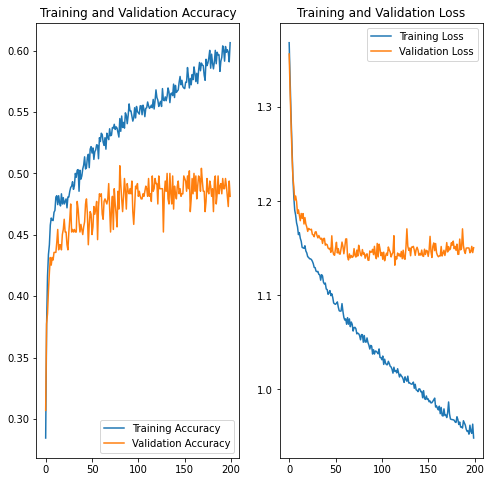

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test accuracy :', accuracy)

8/8 [==============================] - 0s 726us/step - loss: 1.1506 - accuracy: 0.4813
Test accuracy : 0.4813278019428253


# Save the model

In [18]:
# Save the entire model as a SavedModel.
# model.save('./data/humanModel/mode_v0')
model.save('./data/humanModel/model_v0.h5')

In [19]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [20]:
n=1
index = np.random.choice(X_test.shape[0], n, replace=False)
example = X_test[index]

predictions = model.predict(example)[0]
print(predictions)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.  True value: {}"
    .format(np.argmax(predictions), 100 * np.max(predictions), y_test[index])
)

[0.033 0.06  0.681 0.226]
This image most likely belongs to 2 with a 68.10 percent confidence.  True value: 416    0
Name: human_action, dtype: int64


In [21]:
# train, val, test = np.split(data.sample(frac=1), [int(0.8*len(data)), int(0.9*len(data))])
# print(len(train), 'training examples')
# print(len(val), 'validation examples')
# print(len(test), 'test examples')

# def df_to_dataset(dataframe, shuffle=True, batch_size=32):
#   df = dataframe.copy()
#   labels = df.pop('human_action')
#   # Reshape each vector to matrix 6x2
#   df = df.to_numpy().reshape(df.shape[0], 6, 2)
#   df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
#   ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
#   ds = ds.batch(batch_size)
#   ds = ds.prefetch(batch_size)
#   return ds

# def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
#   # Create a layer that turns strings into integer indices.
#   if dtype == 'string':
#     index = layers.StringLookup(max_tokens=max_tokens)
#   # Otherwise, create a layer that turns integer values into integer indices.
#   else:
#     index = layers.IntegerLookup(max_tokens=max_tokens)

#   # Prepare a `tf.data.Dataset` that only yields the feature.
#   feature_ds = dataset.map(lambda x, y: x[name])

#   # Learn the set of possible values and assign them a fixed integer index.
#   index.adapt(feature_ds)

#   # Encode the integer indices.
#   encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

#   # Apply multi-hot encoding to the indices. The lambda function captures the
#   # layer, so you can use them, or include them in the Keras Functional model later.
#   return lambda feature: encoder(index(feature))

# batch_size = 64
# train_ds = df_to_dataset(train, batch_size=batch_size)
# val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
# test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# all_inputs = []
# encoded_features = []

# categorical_cols = ['computer_x', 'computer_y', 'human_x', 'human_y', 'stag_x', 'stag_y',
#        'shrub1_x', 'shrub1_y', 'shrub2_x', 'shrub2_y', 'shrub3_x', 'shrub3_y']

# for header in categorical_cols:
#   categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int32')
#   encoding_layer = get_category_encoding_layer(name=header,
#                                                dataset=train_ds,
#                                                dtype='int32',
#                                                max_tokens=5)
#   encoded_categorical_col = encoding_layer(categorical_col)
#   all_inputs.append(categorical_col)
#   encoded_features.append(encoded_categorical_col)

# num_classes = 4

# all_features = tf.keras.layers.concatenate(encoded_features)
# x = tf.keras.layers.Dense(32, activation="relu")(all_features)
# x = tf.keras.layers.Dense(24, activation="relu")(x)
# x = tf.keras.layers.Dense(8, activation="relu")(x)
# # x = tf.keras.layers.Dropout(0.5)(x)
# output = tf.keras.layers.Dense(num_classes)(x)

# model = tf.keras.Model(all_inputs, output)

# model.compile(optimizer='adam',
#             #   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#             loss = 'sparse_categorical_crossentropy',
#             metrics=["accuracy"])

# # Use `rankdir='LR'` to make the graph horizontal.
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

# model.fit(train_ds, epochs=100, validation_data=val_ds)

# loss, accuracy = model.evaluate(test_ds)
# print("Accuracy", accuracy)